In [2]:
%load_ext autoreload
%autoreload 2

from mutabledataset import SimpleDataset
from agent import RationalAgent
from simulation import Simulation
from learner import LogisticLearner
import plot

import numpy as np
import pandas as pd


def print_table(df):
    young = plot.count_df(df, [{'group': 0, 'credit_h': 1}, {'group': 0, 'credit_h': 0}])
    young_n = young.sum()
    young = young / young.sum() * 100

    old = plot.count_df(df, [{'group': 1, 'credit_h': 1}, {'group': 1, 'credit_h': 0}])
    old_n = old.sum()
    old = old / old.sum() * 100
    tbl = pd.DataFrame(data=[young,old], index=['0 unprivileged ('+str(young_n)+')', '1 privileged ('+str(old_n)+')'], columns=['Good Credit', 'Bad Credit'])
    print("Avg grp 1: ", np.average(plot._df_selection(df, {'group':1})['x']))
    print("Avg grp 0: ", np.average(plot._df_selection(df, {'group':0})['x']))
    print("Difference: ", abs(np.average(plot._df_selection(df, {'group':1})['x']) - np.average(plot._df_selection(df, {'group':0})['x'])))
    return (tbl)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
cost_lambda = lambda x_new, x: x_new/2.+1*abs(x_new-x)/4.
cost_fixed = lambda size: np.abs(np.random.normal(loc=0.5,size=size))

g = SimpleDataset(mutable_features=['x'],
        domains={'x': 'auto'},
        discrete=['x'],
        cost_fns={'x': cost_lambda})

sim = Simulation(g,
        RationalAgent,
        LogisticLearner(),
        cost_fixed)




# Dataset Description

In [4]:
print(list(g.discrete_permutations()[1]))
sim.start_simulation(include_protected=True)

[('a',), ('u',), ('t',), ('o',)]
Train:  (1000, 2) , Test:  (1000, 2)


/home/dan/ETH/ba/simulation/mutabledataset.py:89: UserWarning: Use set of values present in dataset to infer domain for feature x
  warnings.warn("Use set of values present in dataset to infer domain for feature " + ft)


Accuracy (h) pre 0.899
Accuracy (h) post 0.944
Accuracy (h*) post 0.94
eps =  0.0
y=1 1350.0  <-  871.0


# Simulation w/o fairness constraints

## Pre Simulation (No Aff. Action)

In [5]:
print_table(sim.dataset_df)
from sklearn.metrics import confusion_matrix
print("Cf matrix grp 0")

print(confusion_matrix(plot._df_selection(sim.dataset_df, {'group':0})['y'], plot._df_selection(sim.dataset_df, {'group':0})['credit_h']))


print("Cf matrix grp 1")
print(confusion_matrix(plot._df_selection(sim.dataset_df, {'group':1})['y'], plot._df_selection(sim.dataset_df, {'group':1})['credit_h']))

Avg grp 1:  0.6408404255319149
Avg grp 0:  0.4802553191489361
Difference:  0.1605851063829788
Cf matrix grp 0
[[792  28]
 [ 48 132]]
Cf matrix grp 1
[[255  54]
 [ 56 635]]


## Post Simulation (No Aff. Action)

group 0


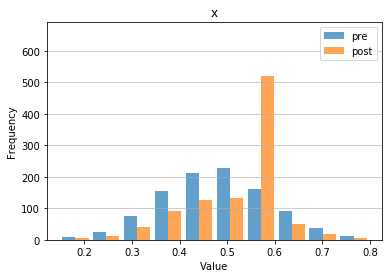

group 1


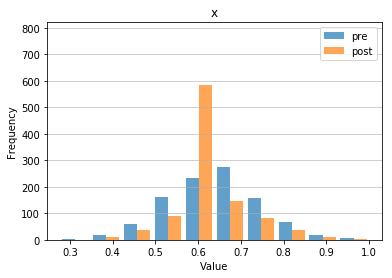

Avg grp 1:  0.6184255319148937
Avg grp 0:  0.5287872340425532
Difference:  0.08963829787234046


,Good Credit,Bad Credit
0 unprivileged (1000),53.1,46.9
1 privileged (1000),82.5,17.5


In [6]:
print("group 0")
plot.plot_mutable_features(sim,selection_criteria={'group':0})
print("group 1")
plot.plot_mutable_features(sim,selection_criteria={'group':1})
print_table(sim.dataset_new_df)

# Affirmative Action

In [7]:
from learner import StatisticalParityLogisticLearner

g = SimpleDataset(mutable_features=['x'],
        domains={'x': 'auto'},
        discrete=['x'],
        cost_fns={'x': cost_lambda})

privileged_groups = [{'group': 1}]
unprivileged_groups = [{'group': 0}]

 

sim = Simulation(g,
                 RationalAgent,
                 StatisticalParityLogisticLearner(privileged_groups,
                                           unprivileged_groups, 0.001),
                 cost_fixed)

sim.start_simulation(include_protected=True)



Train:  (1000, 2) , Test:  (1000, 2)
{'group': 1}


/home/dan/ETH/ba/simulation/mutabledataset.py:89: UserWarning: Use set of values present in dataset to infer domain for feature x
  warnings.warn("Use set of values present in dataset to infer domain for feature " + ft)


Accuracy (h) pre 0.368
Accuracy (h) post 0.419
{'group': 1}
Accuracy (h*) post 0.424
eps =  0.01
y=1 874.0  <-  808.0


## Pre Simulation (Aff. Action)

In [8]:
print_table(sim.dataset_df)

Avg grp 1:  0.6664719101123596
Avg grp 0:  0.5075280898876404
Difference:  0.1589438202247192


,Good Credit,Bad Credit
0 unprivileged (1000),66.9,33.1
1 privileged (1000),68.6,31.4


## Post Simulation (Aff. Action)

group 0


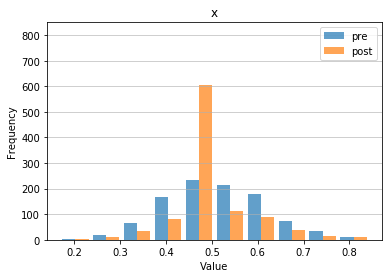

group 1


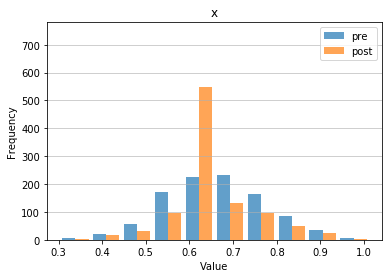

Avg grp 1:  0.6466741573033709
Avg grp 0:  0.4858764044943821
Difference:  0.16079775280898878


,Good Credit,Bad Credit
0 unprivileged (1000),83.6,16.4
1 privileged (1000),81.9,18.1


In [9]:
print("group 0")
plot.plot_mutable_features(sim,selection_criteria={'group':0})
print("group 1")
plot.plot_mutable_features(sim,selection_criteria={'group':1})
print_table(sim.dataset_new_df)

# EqOdds

In [10]:
from learner import EqOddsPostprocessingLogisticLearner

g = SimpleDataset(mutable_features=[],
        domains={'x': 'auto'},
        discrete=['x'],
        cost_fns={'x': cost_lambda})

privileged_groups = [{'group': 1}]
unprivileged_groups = [{'group': 0}]

sim = Simulation(g,
                 RationalAgent,
                 EqOddsPostprocessingLogisticLearner(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups),
                 cost_fixed)
print(sim.dataset.unfavorable_label)
sim.start_simulation(include_protected=True)

0.0
Train:  (1000, 2) , Test:  (1000, 2)
Base rate priv: 0.6724470134874759
Base rate unpriv: 0.22453222453222454
priv_cost 0.2247271309604545 unpriv cost 0.06859881287934548
t priv_cost 0.6724470134874759 t unpriv cost 0.22453222453222463
did not change 2000
97 100 deciding 1.0
did not change 100
68 100 deciding 1.0
did not change 100
26 100 deciding 0.0
did not change 100
26 100 deciding 0.0
did not change 100
87 100 deciding 0.0
did not change 100
3 100 deciding 0.0
did not change 100
11 100 deciding 1.0
did not change 100
54 100 deciding 1.0
did not change 100
13 100 deciding 1.0
did not change 100
87 100 deciding 1.0
did not change 100
21 100 deciding 0.0
did not change 100
100 100 deciding 0.0
did not change 100
74 100 deciding 1.0
did not change 100
43 100 deciding 1.0
did not change 100
52 100 deciding 1.0
did not change 100
97 100 deciding 1.0
did not change 100
67 100 deciding 0.0
did not change 100
21 100 deciding 0.0
did not change 100
81 100 deciding 0.0
did not change 100

/home/dan/ETH/ba/simulation/mutabledataset.py:89: UserWarning: Use set of values present in dataset to infer domain for feature x
  warnings.warn("Use set of values present in dataset to infer domain for feature " + ft)


67 100 deciding 1.0
did not change 100
16 100 deciding 1.0
did not change 100
90 100 deciding 1.0
did not change 100
88 100 deciding 1.0
did not change 100
54 100 deciding 1.0
did not change 100
53 100 deciding 1.0
did not change 100
74 100 deciding 1.0
did not change 100
5 100 deciding 1.0
did not change 100
79 100 deciding 1.0
did not change 100
78 100 deciding 1.0
did not change 100
88 100 deciding 1.0
did not change 100
45 100 deciding 0.0
did not change 100
11 100 deciding 0.0
did not change 100
32 100 deciding 1.0
did not change 100
45 100 deciding 1.0
did not change 100
96 100 deciding 0.0
did not change 100
91 100 deciding 0.0
did not change 100
1 100 deciding 1.0
did not change 100
25 100 deciding 1.0
did not change 100
10 100 deciding 1.0
did not change 100
63 100 deciding 1.0
did not change 100
33 100 deciding 1.0
did not change 100
21 100 deciding 1.0
did not change 100
85 100 deciding 0.0
did not change 100
35 100 deciding 0.0
did not change 100
51 100 deciding 1.0
did not

99 100 deciding 0.0
did not change 100
72 100 deciding 1.0
did not change 100
81 100 deciding 1.0
did not change 100
39 100 deciding 0.0
did not change 100
40 100 deciding 0.0
did not change 100
38 100 deciding 0.0
did not change 100
14 100 deciding 0.0
did not change 100
51 100 deciding 1.0
did not change 100
23 100 deciding 1.0
did not change 100
87 100 deciding 0.0
did not change 100
56 100 deciding 0.0
did not change 100
96 100 deciding 0.0
did not change 100
56 100 deciding 0.0
did not change 100
52 100 deciding 1.0
did not change 100
57 100 deciding 1.0
did not change 100
38 100 deciding 1.0
did not change 100
99 100 deciding 1.0
did not change 100
81 100 deciding 0.0
did not change 100
90 100 deciding 0.0
did not change 100
42 100 deciding 0.0
did not change 100
3 100 deciding 0.0
did not change 100
55 100 deciding 1.0
did not change 100
48 100 deciding 1.0
did not change 100
60 100 deciding 1.0
did not change 100
2 100 deciding 1.0
did not change 100
27 100 deciding 1.0
did not

77 100 deciding 1.0
did not change 100
10 100 deciding 1.0
did not change 100
41 100 deciding 1.0
did not change 100
63 100 deciding 1.0
did not change 100
48 100 deciding 1.0
did not change 100
12 100 deciding 1.0
did not change 100
3 100 deciding 1.0
did not change 100
64 100 deciding 0.0
did not change 100
95 100 deciding 0.0
did not change 100
80 100 deciding 1.0
did not change 100
31 100 deciding 1.0
did not change 100
55 100 deciding 1.0
did not change 100
63 100 deciding 1.0
did not change 100
43 100 deciding 1.0
did not change 100
12 100 deciding 1.0
did not change 100
27 100 deciding 1.0
did not change 100
59 100 deciding 1.0
did not change 100
48 100 deciding 1.0
did not change 100
16 100 deciding 1.0
did not change 100
96 100 deciding 1.0
did not change 100
73 100 deciding 1.0
did not change 100
37 100 deciding 0.0
did not change 100
29 100 deciding 0.0
did not change 100
88 100 deciding 1.0
did not change 100
23 100 deciding 1.0
did not change 100
37 100 deciding 1.0
did no

40 100 deciding 1.0
did not change 100
77 100 deciding 1.0
did not change 100
25 100 deciding 1.0
did not change 100
70 100 deciding 1.0
did not change 100
8 100 deciding 1.0
did not change 100
22 100 deciding 0.0
did not change 100
47 100 deciding 0.0
did not change 100
23 100 deciding 0.0
did not change 100
85 100 deciding 0.0
did not change 100
59 100 deciding 0.0
did not change 100
10 100 deciding 0.0
did not change 100
31 100 deciding 0.0
did not change 100
11 100 deciding 0.0
did not change 100
31 100 deciding 1.0
did not change 100
15 100 deciding 1.0
did not change 100
36 100 deciding 1.0
did not change 100
38 100 deciding 1.0
did not change 100
84 100 deciding 0.0
did not change 100
48 100 deciding 0.0
did not change 100
25 100 deciding 1.0
did not change 100
5 100 deciding 1.0
did not change 100
27 100 deciding 1.0
did not change 100
94 100 deciding 1.0
did not change 100
61 100 deciding 1.0
did not change 100
56 100 deciding 1.0
did not change 100
33 100 deciding 0.0
did not

80 100 deciding 1.0
did not change 100
25 100 deciding 1.0
did not change 100
18 100 deciding 1.0
did not change 100
67 100 deciding 0.0
did not change 100
63 100 deciding 0.0
did not change 100
88 100 deciding 0.0
did not change 100
6 100 deciding 0.0
did not change 100
67 100 deciding 1.0
did not change 100
56 100 deciding 1.0
did not change 100
63 100 deciding 1.0
did not change 100
21 100 deciding 1.0
did not change 100
44 100 deciding 0.0
did not change 100
57 100 deciding 0.0
did not change 100
72 100 deciding 1.0
did not change 100
16 100 deciding 1.0
did not change 100
31 100 deciding 1.0
did not change 100
78 100 deciding 1.0
did not change 100
36 100 deciding 1.0
did not change 100
54 100 deciding 1.0
did not change 100
53 100 deciding 1.0
did not change 100
69 100 deciding 1.0
did not change 100
100 100 deciding 0.0
did not change 100
82 100 deciding 0.0
did not change 100
78 100 deciding 0.0
did not change 100
31 100 deciding 0.0
did not change 100
64 100 deciding 1.0
did n

58 100 deciding 1.0
did not change 100
16 100 deciding 1.0
did not change 100
56 100 deciding 0.0
did not change 100
6 100 deciding 0.0
did not change 100
53 100 deciding 0.0
did not change 100
1 100 deciding 0.0
did not change 100
42 100 deciding 1.0
did not change 100
22 100 deciding 1.0
did not change 100
43 100 deciding 1.0
did not change 100
71 100 deciding 1.0
did not change 100
94 100 deciding 1.0
did not change 100
23 100 deciding 1.0
did not change 100
7 100 deciding 0.0
did not change 100
19 100 deciding 0.0
did not change 100
47 100 deciding 1.0
did not change 100
99 100 deciding 1.0
did not change 100
51 100 deciding 1.0
did not change 100
40 100 deciding 1.0
did not change 100
45 100 deciding 1.0
did not change 100
62 100 deciding 1.0
did not change 100
92 100 deciding 0.0
did not change 100
90 100 deciding 0.0
did not change 100
50 100 deciding 1.0
did not change 100
25 100 deciding 1.0
did not change 100
79 100 deciding 1.0
did not change 100
57 100 deciding 1.0
did not 

23 100 deciding 0.0
did not change 100
23 100 deciding 1.0
did not change 100
99 100 deciding 1.0
did not change 100
52 100 deciding 1.0
did not change 100
85 100 deciding 1.0
did not change 100
92 100 deciding 0.0
did not change 100
72 100 deciding 0.0
did not change 100
61 100 deciding 0.0
did not change 100
71 100 deciding 0.0
did not change 100
39 100 deciding 0.0
did not change 100
91 100 deciding 0.0
did not change 100
85 100 deciding 1.0
did not change 100
17 100 deciding 1.0
did not change 100
68 100 deciding 0.0
did not change 100
90 100 deciding 0.0
did not change 100
4 100 deciding 1.0
did not change 100
19 100 deciding 1.0
did not change 100
95 100 deciding 1.0
did not change 100
20 100 deciding 1.0
did not change 100
64 100 deciding 1.0
did not change 100
18 100 deciding 1.0
did not change 100
5 100 deciding 1.0
did not change 100
40 100 deciding 1.0
did not change 100
18 100 deciding 1.0
did not change 100
72 100 deciding 1.0
did not change 100
41 100 deciding 0.0
did not

97 100 deciding 1.0
did not change 100
73 100 deciding 0.0
did not change 100
22 100 deciding 0.0
did not change 100
59 100 deciding 1.0
did not change 100
42 100 deciding 1.0
did not change 100
12 100 deciding 1.0
did not change 100
26 100 deciding 1.0
did not change 100
5 100 deciding 0.0
did not change 100
51 100 deciding 0.0
did not change 100
19 100 deciding 0.0
did not change 100
78 100 deciding 0.0
did not change 100
32 100 deciding 1.0
did not change 100
61 100 deciding 1.0
did not change 100
27 100 deciding 0.0
did not change 100
67 100 deciding 0.0
did not change 100
71 100 deciding 0.0
did not change 100
74 100 deciding 0.0
did not change 100
71 100 deciding 1.0
did not change 100
13 100 deciding 1.0
did not change 100
62 100 deciding 1.0
did not change 100
72 100 deciding 1.0
did not change 100
51 100 deciding 1.0
did not change 100
53 100 deciding 1.0
did not change 100
40 100 deciding 1.0
did not change 100
27 100 deciding 1.0
did not change 100
90 100 deciding 0.0
did no

82 100 deciding 1.0
did not change 100
67 100 deciding 0.0
did not change 100
67 100 deciding 0.0
did not change 100
50 100 deciding 1.0
did not change 100
53 100 deciding 1.0
did not change 100
45 100 deciding 0.0
did not change 100
22 100 deciding 0.0
did not change 100
97 100 deciding 1.0
did not change 100
60 100 deciding 1.0
did not change 100
88 100 deciding 0.0
did not change 100
65 100 deciding 0.0
did not change 100
69 100 deciding 1.0
did not change 100
96 100 deciding 1.0
did not change 100
55 100 deciding 1.0
did not change 100
86 100 deciding 1.0
did not change 100
31 100 deciding 1.0
did not change 100
80 100 deciding 1.0
did not change 100
47 100 deciding 1.0
did not change 100
59 100 deciding 1.0
did not change 100
23 100 deciding 1.0
did not change 100
50 100 deciding 1.0
did not change 100
21 100 deciding 1.0
did not change 100
97 100 deciding 1.0
did not change 100
79 100 deciding 1.0
did not change 100
64 100 deciding 1.0
did not change 100
76 100 deciding 1.0
did n

97 100 deciding 0.0
did not change 100
69 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
85 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
96 100 deciding 0.0
did not change 100
78 100 deciding 0.0
did not change 100
24 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
51 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
49 100 deciding 0.0
did not change 100
75 100 deciding 0.0
did not change 100
53 100 deciding 0.0
did not change 100
96 100 deciding 0.0
did not change 100
11 100 deciding 0.0
did not change 100
80 100 deciding 0.0
did not change 100
55 100 deciding 0.0
did not change 100
14 100 deciding 0.0
did not change 100
49 100 deciding 0.0
did not change 100
67 100 deciding 0.0
did not change 100
32 100 deciding 0.0
did not change 100
71 100 deciding 0.0
did not change 100
14 100 deciding 0.0
fav: 1.0
labels did change after eq

99 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
5 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
91 100 deciding 0.0
did not change 100
44 100 deciding 0.0
did not change 100
84 100 deciding 0.0
did not change 100
41 100 deciding 0.0
did not change 100
43 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
97 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
5 100 deciding 0.0
did not change 100
66 100 deciding 0.0
did not change 100
10 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
51 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
90 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
100 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
98 100 deciding 0.0
fav: 1.0
labels did change 

22 100 deciding 0.0
did not change 100
99 100 deciding 0.0
did not change 100
75 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
13 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
45 100 deciding 0.0
did not change 100
76 100 deciding 0.0
did not change 100
52 100 deciding 0.0
did not change 100
92 100 deciding 0.0
did not change 100
41 100 deciding 0.0
did not change 100
6 100 deciding 0.0
did not change 100
22 100 deciding 0.0
did not change 100
1 100 deciding 0.0
did not change 100
37 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
79 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
70 100 deciding 0.0
did not change 100
27 100 deciding 0.0
did not change 100
18 100 deciding 0.0
did not change 100
5 100 deciding 0.0
did not change 100
30 100 deciding 0.0
did not change 100
30 100 deciding 0.0
did not change 100
87 100 deciding 0.0

1 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
17 100 deciding 0.0
did not change 100
40 100 deciding 0.0
did not change 100
6 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
18 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
51 100 deciding 0.0
did not change 100
2 100 deciding 0.0
did not change 100
34 100 deciding 0.0
did not change 100
9 100 deciding 0.0
did not change 100
80 100 deciding 0.0
did not change 100
82 100 deciding 0.0
did not change 100
73 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
90 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
70 100 deciding 0.0
did not change 100
12 100 deciding 0.0
did not change 100
8 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
5 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] 

84 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
65 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
94 100 deciding 0.0
did not change 100
26 100 deciding 0.0
did not change 100
39 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
77 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
81 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
55 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
25 100 deciding 0.0
did not change 100
48 100 deciding 0.0
did not change 100
20 100 deciding 0.0
did not change 100
16 100 deciding 0.0
did not change 100
16 100 deciding 0.0
did not change 100
82 100 deciding 0.0
did not change 100
42 100 deciding 0.0
did not change 100
52 100 deciding 0.0
did not change 100
5 100 deciding 0.0
did not change 100
73 100 deciding 0.0
did not chan

63 100 deciding 0.0
did not change 100
75 100 deciding 0.0
did not change 100
3 100 deciding 0.0
did not change 100
10 100 deciding 0.0
did not change 100
73 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
30 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
86 100 deciding 0.0
did not change 100
30 100 deciding 0.0
did not change 100
39 100 deciding 0.0
did not change 100
94 100 deciding 0.0
did not change 100
52 100 deciding 0.0
did not change 100
49 100 deciding 0.0
did not change 100
71 100 deciding 0.0
did not change 100
64 100 deciding 0.0
did not change 100
40 100 deciding 0.0
did not change 100
48 100 deciding 0.0
did not change 100
10 100 deciding 0.0
did not change 100
33 100 deciding 0.0
did not change 100
51 100 deciding 0.0
did not change 100
62 100 deciding 0.0
did not change 100
30 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
1 100 deciding 0.0
fav: 1.0
l

81 100 deciding 0.0
did not change 100
53 100 deciding 0.0
did not change 100
73 100 deciding 0.0
did not change 100
58 100 deciding 0.0
did not change 100
41 100 deciding 0.0
did not change 100
60 100 deciding 0.0
did not change 100
82 100 deciding 0.0
did not change 100
44 100 deciding 0.0
did not change 100
42 100 deciding 0.0
did not change 100
79 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
61 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
66 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
16 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
87 100 deciding 0.0
did not change 100
97 100 deciding 0.0
did not change 100
6 100 deciding 0.0
did not change 100
68 100 deciding 0.0
did not change 100
37 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
55 100 deciding 0.0
fav: 1.0
labels did chan

labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
25 100 deciding 0.0
did not change 100
64 100 deciding 0.0
did not change 100
38 100 deciding 0.0
did not change 100
73 100 deciding 0.0
did not change 100
12 100 deciding 0.0
did not change 100
83 100 deciding 0.0
did not change 100
90 100 deciding 0.0
did not change 100
49 100 deciding 0.0
did not change 100
69 100 deciding 0.0
did not change 100
44 100 deciding 0.0
did not change 100
39 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
78 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
24 100 deciding 0.0
did not change 100
15 100 deciding 0.0
did not change 100
38 100 deciding 0.0
did not change 100
67 100 deciding 0.0
did not change 100
98 100 deciding 0.0
did not change 100
48 100 deciding 0.0
did not change 100
68 100 deciding 0.0
did not change 100
90 100 deciding 0.0
did not change 100
62 100 deciding 0.0
did not change 100
24 100 deciding 0.

100 100 deciding 0.0
did not change 100
59 100 deciding 0.0
did not change 100
92 100 deciding 0.0
did not change 100
42 100 deciding 0.0
did not change 100
18 100 deciding 0.0
did not change 100
66 100 deciding 0.0
did not change 100
83 100 deciding 0.0
did not change 100
8 100 deciding 0.0
did not change 100
77 100 deciding 0.0
did not change 100
69 100 deciding 0.0
did not change 100
55 100 deciding 0.0
did not change 100
31 100 deciding 0.0
did not change 100
63 100 deciding 0.0
did not change 100
61 100 deciding 0.0
did not change 100
49 100 deciding 0.0
did not change 100
41 100 deciding 0.0
did not change 100
86 100 deciding 0.0
did not change 100
75 100 deciding 0.0
did not change 100
73 100 deciding 0.0
did not change 100
30 100 deciding 0.0
did not change 100
76 100 deciding 0.0
did not change 100
18 100 deciding 0.0
did not change 100
68 100 deciding 0.0
did not change 100
97 100 deciding 0.0
did not change 100
64 100 deciding 0.0
did not change 100
48 100 deciding 0.0
did n

18 100 deciding 0.0
did not change 100
45 100 deciding 0.0
did not change 100
86 100 deciding 0.0
did not change 100
62 100 deciding 0.0
did not change 100
81 100 deciding 0.0
did not change 100
50 100 deciding 0.0
did not change 100
13 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
95 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
95 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
11 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
84 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
25 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
52 100 deciding 0.0
did not change 100
38 100 deciding 0.0
did not change 100
42 100 deciding 0.0
did not change 100
88 100 deciding 0.0
did not change 100
84 100 deciding 0.0
did not change 100
62 100 deciding 0.0
did not cha

44 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
46 100 deciding 0.0
fav: 1.0
labels did change after eqodds. 1.0 to [[0.0]] for group 0.0
9 100 deciding 0.0
did not change 100
2 100 deciding 0.0
did not change 100
87 100 deciding 0.0
did not change 100
51 100 deciding 0.0
did not change 100
2 100 deciding 0.0
did not change 100
25 100 deciding 0.0
did not change 100
15 100 deciding 0.0
did not change 100
60 100 deciding 0.0
did not change 100
36 100 deciding 0.0
did not change 100
30 100 deciding 0.0
did not change 100
80 100 deciding 0.0
did not change 100
41 100 deciding 0.0
did not change 100
9 100 deciding 0.0
did not change 100
68 100 deciding 0.0
did not change 100
43 100 deciding 0.0
did not change 100
71 100 deciding 0.0
did not change 100
2 100 deciding 0.0
did not change 100
52 100 deciding 0.0
did not change 100
68 100 deciding 0.0
did not change 100
16 100 deciding 0.0
did not change 100
84 100 deciding 0.0
did not change 100
41 100

## Pre Simulation (EqOdds)

In [ ]:
print_table(sim.dataset_df)

# 